In [ ]:
#Importar librerias
import pandas as pd
import numpy as np
import glob
import os
import re

In [ ]:
#Definir funciones
def normalize_ciuu(s: str) -> str:
  if pd.isna(s):
    return ''
  s2 = str(s).upper()
  s2 = re.sub(r'[\.\s\-]', '', s2)
  return s2

def safe_float(x):
  try:
    return float(x)
  except:
    return np.nan

def find_ruc_across_provinces():
  files = glob.glob("SRI_RUC_*.csv")
  if not files:
    return pd.DataFrame()
  parts = []
  for f in files:
    try:
      df = pd.read_csv(f, sep='|', encoding='latin1', dtype={'NUMERO_RUC': str}, low_memory=False)
    except Exception as e:
      print(f"Error leyendo {f}: {e}")
      continue
    if 'NUMERO_RUC' in df.columns:
      df['NUMERO_RUC'] = df['NUMERO_RUC'].astype(str).str.zfill(13)
    for col in ['CODIGO_CIIU','DESCRIPCION_PROVINCIA_EST','DESCRIPCION_CANTON_EST']:
      if col in df.columns:
          df[col] = df[col].astype(str)
    parts.append(df)
  if not parts:
    return pd.DataFrame()
  return pd.concat(parts, ignore_index=True)

In [ ]:
# Cargar tablas RUC
df_ruc_all = find_ruc_across_provinces()
if df_ruc_all.empty:
  print("No se encontraron archivos")
else:
  # crear columnas unificadas si existen
  if 'NUMERO_RUC' in df_ruc_all.columns:
    df_ruc_all['RUC'] = df_ruc_all['NUMERO_RUC'].astype(str).str.zfill(13)
  else:
    df_ruc_all['RUC'] = df_ruc_all.index.astype(str)

  # normalizar CIIU y ubicaciones si existen
  if 'CODIGO_CIIU' in df_ruc_all.columns:
    df_ruc_all['CODIGO_CIIU'] = df_ruc_all['CODIGO_CIIU'].astype(str).apply(lambda x: normalize_ciuu(x))
  else:
    df_ruc_all['CODIGO_CIIU'] = ''
  if 'DESCRIPCION_PROVINCIA_EST' in df_ruc_all.columns:
    df_ruc_all['PROVINCIA'] = df_ruc_all['DESCRIPCION_PROVINCIA_EST'].astype(str).str.upper()
  else:
    df_ruc_all['PROVINCIA'] = ''
  if 'DESCRIPCION_CANTON_EST' in df_ruc_all.columns:
    df_ruc_all['CANTON'] = df_ruc_all['DESCRIPCION_CANTON_EST'].astype(str).str.upper()
  else:
    df_ruc_all['CANTON'] = ''

# Inputs del usuario
print("\n--- Entradas del usuario ---")
ruc_input = input("Ingrese su RUC (13 dígitos): ").strip().zfill(13)
year_input = input("Ingrese el año fiscal a analizar (ej. 2025): ").strip()
try:
  year_input_i = int(year_input)
except:
  print("Año inválido, se usará el valor literal ingresado para filtrar.")
  year_input_i = None

ventas_user = safe_float(input("Ingrese VENTAS_NETAS_TARIFA_GRAVADA (USD): ").strip())
compras_user = safe_float(input("Ingrese COMPRAS_NETAS_TARIFA_GRAVADA (USD): ").strip())
utilidad_antes_impuestos = safe_float(input("Ingrese UTILIDAD ANTES DE IMPUESTOS (USD): ").strip())
activos_user = safe_float(input("Ingrese ACTIVOS (USD): ").strip())
patrimonio_user = safe_float(input("Ingrese PATRIMONIO (USD): ").strip())
utilidad_neta_user = safe_float(input("Ingrese UTILIDAD NETA (USD): ").strip())


--- Entradas del usuario ---
Ingrese su RUC (13 dígitos): 0992349921001
Ingrese el año fiscal a analizar (ej. 2025): 2024
Ingrese VENTAS_NETAS_TARIFA_GRAVADA (USD): 16863068.61
Ingrese COMPRAS_NETAS_TARIFA_GRAVADA (USD): 5000000.00
Ingrese UTILIDAD ANTES DE IMPUESTOS (USD): 834064.10
Ingrese ACTIVOS (USD): 11235992.76
Ingrese PATRIMONIO (USD): 2563502.82
Ingrese UTILIDAD NETA (USD): 423161.37


In [ ]:
# 2. Encontrar empresa en RUC cargados
empresa_row = pd.DataFrame()
if not df_ruc_all.empty:
  empresa_row = df_ruc_all[df_ruc_all['RUC'] == ruc_input]

if empresa_row.empty:
  print("\nRUC no encontrado en los archivos SRI_RUC_*.csv.")
  ciiu6_input = input("Ingrese manualmente su CIIU6 (ej. C2410): ").strip()
  ciiu6_input = normalize_ciuu(ciiu6_input)
  provincia_user = input("Ingrese su PROVINCIA (ej. SANTA ELENA): ").strip().upper()
  canton_user = input("Ingrese su CANTON (ej. LA LIBERTAD): ").strip().upper()
else:
  # tomar primera fila si hay duplicados
  emp = empresa_row.iloc[0]
  ciiu6_input = emp.get('CODIGO_CIIU', '')
  if pd.isna(ciiu6_input) or ciiu6_input == '':
    ciiu6_input = input("CIIU no registrado: ingrese su CIIU6 (ej. C2410): ").strip()
  ciiu6_input = normalize_ciuu(ciiu6_input)
  provincia_user = emp.get('PROVINCIA', '').upper()
  canton_user = emp.get('CANTON', '').upper()

In [ ]:
# 3. Cálculos empresa
IVA_RATE = 0.15
iva_cobrado_user = ventas_user * IVA_RATE
iva_credito_user = compras_user * IVA_RATE
iva_a_pagar_user = iva_cobrado_user - iva_credito_user

# indicadores financieros de la empresa
margen_operacional_user = (utilidad_antes_impuestos / ventas_user) if ventas_user and ventas_user != 0 else np.nan
roa_user = (utilidad_neta_user / activos_user) if activos_user and activos_user != 0 else np.nan
roe_user = (utilidad_neta_user / patrimonio_user) if patrimonio_user and patrimonio_user != 0 else np.nan

In [ ]:
# 4. Cargar datos y filtrar por año y sector
if not os.path.exists('bi_ranking.csv'):
  print("\nNo se encontró bi_ranking.csv en el directorio. No se podrán extraer benchmarks financieros por CIIU6.")
  bi = pd.DataFrame()
else:
  bi = pd.read_csv('bi_ranking.csv', low_memory=False, encoding='latin1')
  bi.columns = [c.lower() for c in bi.columns]  # normalizar nombres a minúsculas
  # columna de año
  if 'anio' in bi.columns:
    if year_input_i is not None:
      bi = bi[bi['anio'] == year_input_i].copy()
  # limpiar variable ciiu6
  if 'ciiu_n6' in bi.columns:
    bi['ciiu_n6_norm'] = bi['ciiu_n6'].astype(str).apply(lambda x: normalize_ciuu(x))
  elif 'ciiu_n1' in bi.columns:
      # usar n1 en vez de n6
    bi['ciiu_n6_norm'] = bi['ciiu_n1'].astype(str).apply(lambda x: normalize_ciuu(x))
  else:
    bi['ciiu_n6_norm'] = ''
  for col in ['margen_operacional','margen_bruto','rent_ope_activo','rent_neta_ventas','roe','roa']:
    if col in bi.columns:
        bi[col] = pd.to_numeric(bi[col], errors='coerce')

# seleccionar filas del mismo sector
bench_row = pd.DataFrame()
if not bi.empty:
  bench_row = bi[bi['ciiu_n6_norm'] == ciiu6_input]

# calcular benchmarks agregados por sector promedio
bench_agg = {}
if not bench_row.empty:
  # calcular promedio para cada métrica
  for col in ['margen_operacional','rent_ope_activo','rent_neta_ventas','roe','roa']:
    if col in bench_row.columns:
      val = bench_row[col].mean(skipna=True)
      if not np.isnan(val):
        bench_agg[col] = val

In [ ]:
# 5. Calcular promedio IVA sector

#Ingresar Mes
mes_input = int(input("Ingrese el mes a analizar (1-12): "))
sri_file='/content/sri_ventas_2025.csv'

if os.path.exists(sri_file):
  df_sri = pd.read_csv(sri_file, sep='|', encoding='latin1', low_memory=False)
  df_sri.columns = [c.upper() for c in df_sri.columns]

  # Limpiar columnas
  for col in ['VENTAS_NETAS_TARIFA_GRAVADA','COMPRAS_NETAS_TARIFA_GRAVADA','MES','CODIGO_SECTOR_N1','PROVINCIA','CANTON']:
    if col not in df_sri.columns:
      df_sri[col] = 0 if col=='MES' else ''

  df_sri['VENTAS_NETAS_TARIFA_GRAVADA'] = pd.to_numeric(df_sri['VENTAS_NETAS_TARIFA_GRAVADA'].astype(str).str.replace(',','.'), errors='coerce').fillna(0)
  df_sri['COMPRAS_NETAS_TARIFA_GRAVADA'] = pd.to_numeric(df_sri['COMPRAS_NETAS_TARIFA_GRAVADA'].astype(str).str.replace(',','.'), errors='coerce').fillna(0)
  df_sri['IVA_COBRADO'] = df_sri['VENTAS_NETAS_TARIFA_GRAVADA'] * IVA_RATE
  df_sri['IVA_A_PAGAR'] = df_sri['IVA_COBRADO'] - (df_sri['COMPRAS_NETAS_TARIFA_GRAVADA'] * IVA_RATE)

  # Filtrar por sector
  sec_df = df_sri[(df_sri['CODIGO_SECTOR_N1'].str.upper() == ciiu6_input[0].upper()) & (df_sri['MES']==mes_input)]
  avg_iva_sector = sec_df['IVA_A_PAGAR'].mean() if not sec_df.empty else None

  # Lintrar por provincia y cantn
  prov_df = df_sri[(df_sri['PROVINCIA'].str.upper() == provincia_user) & (df_sri['MES']==mes_input)]
  cant_df = df_sri[(df_sri['CANTON'].str.upper() == canton_user) & (df_sri['MES']==mes_input)]
  avg_iva_prov = prov_df['IVA_A_PAGAR'].mean() if not prov_df.empty else None
  avg_iva_canton = cant_df['IVA_A_PAGAR'].mean() if not cant_df.empty else None



Ingrese el mes a analizar (1-12): 5


In [ ]:
# 6. Preparar y mostrar resultados
print("\n\n===== RESULTADOS (Análisis financiero y fiscal) =====\n")
print(f"RUC analizado: {ruc_input}")
print(f"Año: {year_input}")
print(f"CIIU6 usado para comparar (normalizado): {ciiu6_input}")
print(f"Ubicación (Provincia / Cantón): {provincia_user} / {canton_user}")
print("\n-- Indicadores empresa (ingresados) --")
print(f"Ventas netas (gravadas): ${ventas_user:,.2f}")
print(f"Compras netas (gravadas): ${compras_user:,.2f}")
print(f"IVA cobrado (15%): ${iva_cobrado_user:,.2f}")
print(f"IVA crédito (15%): ${iva_credito_user:,.2f}")
print(f"IVA neto (a pagar): ${iva_a_pagar_user:,.2f}")
print(f"Margen operacional estimado (utilidad antes impuestos / ventas): {margen_operacional_user:.2%}" if not np.isnan(margen_operacional_user) else "Margen operativo: N/D")
print(f"ROA estimado (utilidad neta / activos): {roa_user:.2%}" if not np.isnan(roa_user) else "ROA: N/D")
print(f"ROE estimado (utilidad neta / patrimonio): {roe_user:.2%}" if not np.isnan(roe_user) else "ROE: N/D")

print("\n-- Benchmarks sectoriales (bi_ranking por CIIU6 o sector) --")
if bench_agg:
  for k,v in bench_agg.items():
    label = k.replace('_',' ').title()
    print(f"{label}: {v:.2%}")
else:
  print("No hay benchmarks")

print("\n-- Promedios IVA (SRI) --")
if avg_iva_sector is not None:
  print(f"Promedio IVA a pagar por sector (letra = '{ciiu6_input}'): ${avg_iva_sector:,.2f}")
else:
  print("Promedio IVA sectorial: Sin datos (o sri_ventas no disponible).")
if avg_iva_prov is not None:
  print(f"Promedio IVA a pagar en provincia {provincia_user}: ${avg_iva_prov:,.2f}")
if avg_iva_canton is not None:
  print(f"Promedio IVA a pagar en cantón {canton_user}: ${avg_iva_canton:,.2f}")




===== RESULTADOS (Análisis financiero y fiscal) =====

RUC analizado: 0992349921001
Año: 2024
CIIU6 usado para comparar (normalizado): Q881000
Ubicación (Provincia / Cantón): SANTA ELENA / SALINAS

-- Indicadores empresa (ingresados) --
Ventas netas (gravadas): $16,863,068.61
Compras netas (gravadas): $5,000,000.00
IVA cobrado (15%): $2,023,568.23
IVA crédito (15%): $600,000.00
IVA neto (a pagar): $1,423,568.23
Margen operacional estimado (utilidad antes impuestos / ventas): 4.95%
ROA estimado (utilidad neta / activos): 3.77%
ROE estimado (utilidad neta / patrimonio): 16.51%

-- Benchmarks sectoriales (bi_ranking por CIIU6 o sector) --
Margen Operacional: 124.30%
Rent Ope Activo: 219.41%
Rent Neta Ventas: 7.74%
Roe: 33.07%
Roa: 34.96%

-- Promedios IVA (SRI) --
Promedio IVA a pagar por sector (letra = 'Q881000'): $-71,248.09
Promedio IVA a pagar en provincia SANTA ELENA: $-23,271.75
Promedio IVA a pagar en cantón SALINAS: $-18,048.44


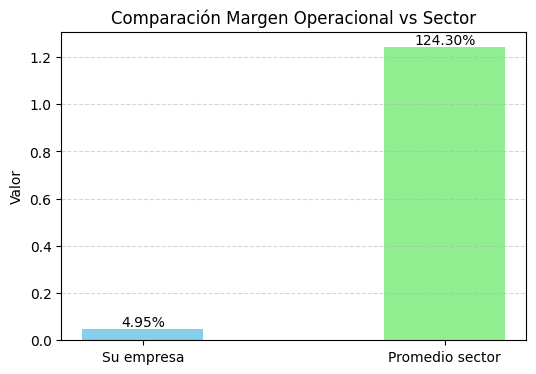

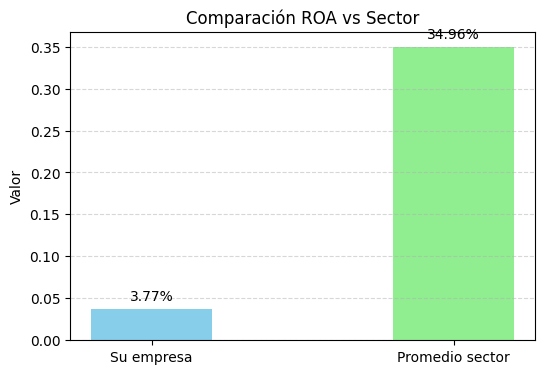

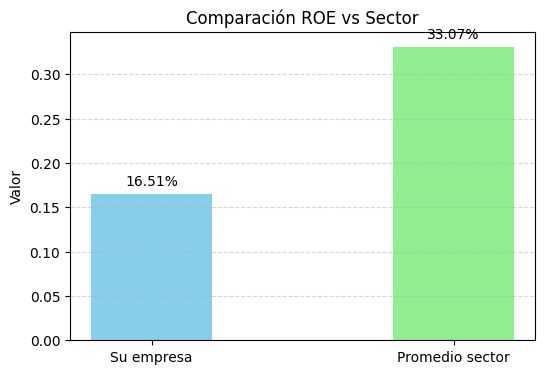

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ratios de la empresa
ratios_empresa = {
    'Margen Operacional': margen_operacional_user,
    'ROA': roa_user,
    'ROE': roe_user}

# Promedios sectoriales
ratios_sector = {}
if not bench_row.empty:
  for col, label in [('margen_operacional', 'Margen Operacional'),
                      ('roa', 'ROA'),
                      ('roe', 'ROE')]:
      if col in bench_row.columns:
        ratios_sector[label] = bench_row[col].mean(skipna=True)
      else:
        ratios_sector[label] = np.nan
else:
  ratios_sector = {label: np.nan for label in ratios_empresa.keys()}

# Función para crear un gráfico por ratio
def plot_ratio(ratio_label, empresa_val, sector_val):
  x = np.arange(2)
  values = [empresa_val, sector_val]
  labels = ['Su empresa', 'Promedio sector']
  colors = ['skyblue', 'lightgreen']

  fig, ax = plt.subplots(figsize=(6,4))
  bars = ax.bar(x, values, color=colors, width=0.4)

  ax.set_ylabel('Valor')
  ax.set_title(f'Comparación {ratio_label} vs Sector')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.grid(axis='y', linestyle='--', alpha=0.5)

  # Añadir valores encima de las barras
  for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2%}', ha='center', fontsize=10)

  plt.show()

# Generar gráficos individuales
plot_ratio('Margen Operacional', ratios_empresa['Margen Operacional'], ratios_sector['Margen Operacional'])
plot_ratio('ROA', ratios_empresa['ROA'], ratios_sector['ROA'])
plot_ratio('ROE', ratios_empresa['ROE'], ratios_sector['ROE'])


In [ ]:
# 7) Interpretación
print("\n\n INFORME\n")

# IVA
if avg_iva_sector is not None and not np.isnan(avg_iva_sector):
  rel_iva_sector = (iva_a_pagar_user - avg_iva_sector) / (abs(avg_iva_sector) if abs(avg_iva_sector)>0 else 1)
  if rel_iva_sector > 0.25:
    print("- IVA: Su IVA a pagar es significativamente mayor que el promedio del sector")
  elif rel_iva_sector > 0.05:
    print("- IVA: Su IVA a pagar es ligeramente mayor que el promedio del sector")
  elif rel_iva_sector < -0.25:
    print("- IVA: Su IVA a pagar es significativamente menor que el promedio del sector. Esto puede indicar mayor uso de compras con IVA (más crédito fiscal), menor actividad gravada o diferencias estacionales.")
  elif rel_iva_sector < -0.05:
    print("- IVA: Su IVA a pagar es ligeramente menor que el promedio del sector")
  else:
    print("- IVA: Su IVA a pagar es similar al promedio del sector")
else:
  print("- IVA: No hay promedio sectorial disponible")

# Ratio
if bench_agg:
  # margin
  if 'margen_operacional' in bench_agg and not np.isnan(bench_agg['margen_operacional']) and not np.isnan(margen_operacional_user):
    relm = (margen_operacional_user - bench_agg['margen_operacional']) / (abs(bench_agg['margen_operacional']) if abs(bench_agg['margen_operacional'])>0 else 1)
    if relm > 0.10:
      print("- Margen operativo: Su margen es significativamente superior al promedio sectorial - buena eficiencia operacional.")
    elif relm < -0.10:
      print("- Margen operativo: Su margen es inferior al promedio sectorial - revise costos y precios.")
    else:
      print("- Margen operativo: Su margen está en línea con el promedio sectorial.")
  # ROA
  if 'roa' in bench_agg and not np.isnan(bench_agg['roa']) and not np.isnan(roa_user):
    rel_roa = (roa_user - bench_agg['roa']) / (abs(bench_agg['roa']) if abs(bench_agg['roa'])>0 else 1)
    if rel_roa > 0.10:
      print("- ROA: Su rentabilidad sobre activos supera al promedio sectorial - buen uso de activos.")
    elif rel_roa < -0.10:
      print("- ROA: Su ROA está por debajo del promedio sectorial - evaluar eficiencia en activos.")
    else:
      print("- ROA: Su ROA está en línea con el promedio sectorial.")
  # ROE
  if 'roe' in bench_agg and not np.isnan(bench_agg['roe']) and not np.isnan(roe_user):
    rel_roe = (roe_user - bench_agg['roe']) / (abs(bench_agg['roe']) if abs(bench_agg['roe'])>0 else 1)
    if rel_roe > 0.10:
      print("- ROE: Su rentabilidad para el patrimonio es mejor que el promedio sectorial.")
    elif rel_roe < -0.10:
      print("- ROE: Su ROE es menor que el promedio sectorial.")
    else:
      print("- ROE: Su ROE está en línea con el promedio sectorial.")
else:
    print("- Benchmarks financieros no disponibles")



 INFORME

- IVA: Su IVA a pagar es significativamente mayor que el promedio del sector
- Margen operativo: Su margen es inferior al promedio sectorial - revise costos y precios.
- ROA: Su ROA está por debajo del promedio sectorial - evaluar eficiencia en activos.
- ROE: Su ROE es menor que el promedio sectorial.
